# Fine-tuning Vision Transformer for Multi-label Image Classification

In [1]:
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
import wandb
from PIL import Image
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as T
from pathlib import Path
from PIL import Image
import datasets
import os
import json
import jsonlines
from timm import create_model
from transformers.optimization import get_cosine_schedule_with_warmup
import evaluate
import seaborn as sns
import matplotlib.pyplot as plt


d:\MA\food-datasets\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading

In [2]:
annotations_path = Path("../data/ingredients-101/Annotations/")
images_path = Path("../data/food-101/images/")
ingredients_path = 'ingredients_simplified.txt'
simplifications_path = Path("../data/ingredients-101/ingredients_simplification/")

In [3]:
def read_data(path, file):
    with open(path / file, 'r') as f:
        data = f.read().strip().split('\n')
    return data

In [4]:
train_images = read_data(annotations_path, 'train_images.txt')
val_images = read_data(annotations_path, 'val_images.txt')
test_images = read_data(annotations_path, 'test_images.txt')

train_labels = read_data(annotations_path, 'train_labels.txt')
val_labels = read_data(annotations_path, 'val_labels.txt')
test_labels = read_data(annotations_path, 'test_labels.txt')

base_ingredients = read_data(simplifications_path, 'baseIngredients.txt')
ingredients_simplified = read_data(annotations_path, ingredients_path)

### Convert Ingredients List to Multi-label Format

In [8]:
corrected_ingredients_simplified = [ingredient.strip() for sublist in ingredients_simplified for ingredient in sublist.split(',')]
# corrected_ingredients_simplified[:10]

['butter',
 'flour',
 'sugar',
 'brown sugar',
 'apple',
 'cinnamon',
 'nut',
 'baby back ribs',
 'apple',
 'salt']

In [9]:
# get only the unique ingredients
unique_ingredients = list(set(corrected_ingredients_simplified))
num_unique_ingredients = len(unique_ingredients)
num_unique_ingredients

227

In [10]:
# sort the ingredients alphabetically
unique_ingredients.sort()

# create a dictionary with the ingredients as keys and the index as values
ingredient_to_idx = {ingredient: idx for idx, ingredient in enumerate(unique_ingredients)}
idx_to_ingredient = {idx: ingredient for ingredient, idx in ingredient_to_idx.items()}

# create the directory if it does not exist
os.makedirs('../data/food-ingredients', exist_ok=True)

# save to a file
with open('../data/food-ingredients/ingredient_to_idx.txt', 'w') as f:
    for key, value in ingredient_to_idx.items():
        f.write(f'{key}, {value}\n')

In [11]:
numerical_ingredients_simplified = [[ingredient_to_idx[ingredient.strip()] for ingredient in sublist.split(',')] for sublist in ingredients_simplified]

numerical_ingredients_simplified[:5]

[[36, 100, 206, 34, 5, 63, 143],
 [10, 5, 183, 141, 34, 224, 105, 54],
 [143, 63, 29, 36, 160, 206, 116, 124, 15],
 [21, 124, 105, 183, 159, 9, 7],
 [94, 204, 105, 190, 156, 42, 224, 91, 27, 78]]

In [12]:
# manually check the correctness of the conversion
print(idx_to_ingredient[183])

print([idx_to_ingredient[idx] for idx in numerical_ingredients_simplified[1]]) 

salt
['baby back ribs', 'apple', 'salt', 'mustard', 'brown sugar', 'worcestershire', 'gin', 'chili']


In [13]:
# Create a dictionary to map each class to its ingredients
class_to_ingredients = {i: ingredients for i, ingredients in enumerate(ingredients_simplified)}
class_to_ingredients

# save to a file
with open('../data/food-ingredients/class_to_ingredients.jsonl', 'w') as f:
    for key, value in class_to_ingredients.items():
        f.write(json.dumps({key: value}) + '\n')

### Create Dataset

In [15]:
# create a jsonl file with the data

with jsonlines.open('../data/food-ingredients/train.jsonl', 'w') as writer:
    for image, label in zip(train_images, train_labels):
        ingredients = class_to_ingredients[int(label)]
        ingredients_numeric = [ingredient_to_idx[ingredient] for ingredient in ingredients.split(',')]
        writer.write({'image': str(images_path) + '/' + image + '.jpg', 'ingredients': ingredients_numeric, 'ingredients_names': ingredients.split(','), 'class': int(label), 'class_name': image.split('/')[0]})

with jsonlines.open('../data/food-ingredients/val.jsonl', 'w') as writer:
    for image, label in zip(val_images, val_labels):
        ingredients = class_to_ingredients[int(label)]
        ingredients_numeric = [ingredient_to_idx[ingredient] for ingredient in ingredients.split(',')]
        writer.write({'image': str(images_path) + '/' + image + '.jpg', 'ingredients': ingredients_numeric, 'ingredients_names': ingredients.split(','), 'class': int(label), 'class_name': image.split('/')[0]})

with jsonlines.open('../data/food-ingredients/test.jsonl', 'w') as writer:
    for image, label in zip(test_images, test_labels):
        ingredients = class_to_ingredients[int(label)]
        ingredients_numeric = [ingredient_to_idx[ingredient] for ingredient in ingredients.split(',')]
        writer.write({'image': str(images_path) + '/' + image + '.jpg', 'ingredients': ingredients_numeric, 'ingredients_names': ingredients.split(','), 'class': int(label), 'class_name': image.split('/')[0]})

In [16]:
# load dataset
data_files = {"train": "../data/food-ingredients/train.jsonl", "val": "../data/food-ingredients/val.jsonl", "test": "../data/food-ingredients/test.jsonl"}

dataset = datasets.load_dataset('json', data_files=data_files)

Generating train split: 68175 examples [00:00, 419684.64 examples/s]
Generating val split: 7575 examples [00:00, 549021.13 examples/s]
Generating test split: 25250 examples [00:00, 861389.99 examples/s]


### Visual Inspection

In [18]:
# def show_samples(ds,rows,cols):
#     # selecting random images with randomstate
#     samples = ds.shuffle(seed=20).select(range(rows*cols))
#     fig = plt.figure(figsize=(cols*4,rows*4))
#     # plotting
#     for i in range(rows*cols):
#         img = samples[i]['image']
#         # add full path and open image
#         img = Image.open(img)

#         labels = samples[i]['ingredients']
#         # getting string labels and combining them with a comma
#         labels = ','.join([idx_to_ingredient[lb] for lb in labels])
#         fig.add_subplot(rows,cols,i+1)
#         plt.imshow(img)
#         plt.title(labels)
#         plt.axis('off')
            
# show_samples(dataset['train'],rows=2,cols=2)

### Perform Transformations

In [19]:
img_size = (224,224)

tfms = T.Compose([
    T.Resize(img_size),
    T.RandomHorizontalFlip(),
    T.RandomRotation(30),
    # T.CenterCrop(img_size),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_tfms = T.Compose([
    T.Resize(img_size),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [20]:
def transforms(batch):
    batch['image'] = [Image.open(x).convert('RGB') for x in batch['image']]
    inputs = [tfms(x) for x in batch['image']]
    batch['pixel_values'] = inputs

    labels = torch.zeros((len(batch['ingredients']), num_unique_ingredients))

    for i, ingredient_indices in enumerate(batch['ingredients']):
        labels[i, ingredient_indices] = 1

    batch['labels'] = labels

    return batch

In [21]:
# Apply the transformations to the dataset
train_dataset = dataset['train'].with_transform(transforms)
valid_dataset = dataset['val'].with_transform(transforms)
test_dataset = dataset['test'].with_transform(transforms)

len(train_dataset), len(valid_dataset), len(test_dataset)

(68175, 7575, 25250)

In [22]:
train_dataset

Dataset({
    features: ['image', 'ingredients', 'ingredients_names', 'class', 'class_name'],
    num_rows: 68175
})

In [23]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.stack([x['labels'] for x in batch]).float()
    }

In [25]:
# create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [26]:
# check size of the data
len(train_loader), len(valid_loader), len(test_loader)

(2131, 237, 790)

## Train Model

In [27]:
os.environ["WANDB_NOTEBOOK_NAME"] = 'swin-fine-tuning-multi-label.ipynb'

In [29]:
import numpy as np

from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score

def multi_label_f1_micro(y_true, y_pred, threshold=0.25, average='micro', labels=None, pos_label=1, sample_weight=None):
    y_pred = (y_pred > threshold).astype(int)
    return f1_score(y_true, y_pred, average=average, labels=labels, pos_label=pos_label, sample_weight=sample_weight, zero_division=0.0)

def multi_label_f1_macro(y_true, y_pred, threshold=0.25, average='macro', labels=None, pos_label=1, sample_weight=None):
    y_pred = (y_pred > threshold).astype(int)
    return f1_score(y_true, y_pred, average=average, labels=labels, pos_label=pos_label, sample_weight=sample_weight, zero_division=0.0)

def multi_label_f1_weighted(y_true, y_pred, threshold=0.25, average='weighted', labels=None, pos_label=1, sample_weight=None):
    y_pred = (y_pred > threshold).astype(int)
    return f1_score(y_true, y_pred, average=average, labels=labels, pos_label=pos_label, sample_weight=sample_weight, zero_division=0.0)

def multi_label_f1_samples(y_true, y_pred, threshold=0.25, average='samples', labels=None, pos_label=1, sample_weight=None):
    y_pred = (y_pred > threshold).astype(int)
    return f1_score(y_true, y_pred, average=average, labels=labels, pos_label=pos_label, sample_weight=sample_weight, zero_division=0.0)

def multi_label_accuracy(y_true, y_pred, threshold=0.25):
    y_pred = (y_pred > threshold).astype(int)
    correct_predictions = np.sum(y_true == y_pred)
    total_predictions = y_true.shape[0] * y_true.shape[1]
    accuracy = correct_predictions / total_predictions
    return accuracy

def multi_label_recall(y_true, y_pred, threshold=0.25, average='micro', labels=None, pos_label=1, sample_weight=None):
    y_pred = (y_pred > threshold).astype(int)
    return recall_score(y_true, y_pred, average=average, labels=labels, pos_label=pos_label, sample_weight=sample_weight, zero_division=0.0)

def multi_label_precision(y_true, y_pred, threshold=0.25, average='micro', labels=None, pos_label=1, sample_weight=None):
    y_pred = (y_pred > threshold).astype(int)
    return precision_score(y_true, y_pred, average=average, labels=labels, pos_label=pos_label, sample_weight=sample_weight, zero_division=0.0)

def multi_label_roc_auc(y_true, y_pred, average='micro', sample_weight=None, max_fpr=None):
    return roc_auc_score(y_true, y_pred, average=average, sample_weight=sample_weight, max_fpr=max_fpr)


In [30]:
import time

from tqdm import tqdm

def train(model_name, batch_size=8, epochs=1, lr=2e-4):
    os.environ["WANDB_DISABLE_SYMLINKS"] = "1"
    wandb.init(project="finetuning-vit-3.0", config={
        "model_name": model_name,
        "batch_size": batch_size,
        "epochs": epochs,
        "learning_rate": lr
    })

    config = wandb.config
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Using {device}')

    # Debug: Model Load
    print("Loading the model...")
    model = create_model(model_name, num_classes=num_unique_ingredients, pretrained=True)

    print(num_unique_ingredients)
    model.to(device)
    print("Model loaded.")

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * len(train_loader)),
        num_training_steps=len(train_loader) * epochs
    )

    for epoch in range(epochs):

        ## Training

        model.train()
        train_metric = evaluate.load('roc_auc', 'multilabel')
        running_loss = 0.0
        predictions, actuals = [], []

        print(f"Starting training epoch {epoch}...")

        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
            inputs = batch['pixel_values'].to(device)
            logits = model(inputs)
            labels = batch['labels'].to(device) 

            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            running_loss += loss.item()
            train_metric.add_batch(references=labels.cpu(), prediction_scores=logits.cpu())

            
            predictions.append(torch.sigmoid(logits).detach().cpu().numpy())
            actuals.append(labels.cpu().numpy())

        predictions = np.vstack(predictions)
        actuals = np.vstack(actuals)

        print("Unique values in labels:", np.unique(actuals))
        is_binary = np.all(np.isin(actuals, [0, 1]))
        print("Data is binary:", is_binary)
        
        
        train_loss = running_loss / len(train_loader)
        train_roc_auc = train_metric.compute(average='micro')['roc_auc']
        train_f1_micro = multi_label_f1_micro(actuals, predictions)
        train_f1_macro = multi_label_f1_macro(actuals, predictions)
        train_f1_weighted = multi_label_f1_weighted(actuals, predictions)
        train_f1_samples = multi_label_f1_samples(actuals, predictions)
        train_accuracy = multi_label_accuracy(actuals, predictions)
        train_recall = multi_label_recall(actuals, predictions)
        train_precision = multi_label_precision(actuals, predictions)

        
        print(f"\n{epoch = }")
        print(f"{train_loss = :.3f} | {train_roc_auc = :.3f}")
        
        wandb.log({"train_loss": train_loss, "train_roc_auc": train_roc_auc, "epoch": epoch, "train_f1_micro": train_f1_micro, "train_f1_macro": train_f1_macro, "train_f1_weighted": train_f1_weighted, "train_f1_samples": train_f1_samples, "train_accuracy": train_accuracy, "train_recall": train_recall, "train_precision": train_precision})
        
        ## Validation

        model.eval()
        running_loss = 0.0
        valid_metric = evaluate.load('roc_auc', 'multilabel')
        
        print(f"Starting validation epoch {epoch}...")
        val_start_time = time.time()

        predictions, actuals = [], []
        
        for batch in tqdm(valid_loader, desc=f"Validation Epoch {epoch}"):
            with torch.no_grad():
                inputs = batch['pixel_values'].to(device)
                logits = model(inputs)
                labels = batch['labels'].to(device) 
            loss = loss_fn(logits, labels)
            running_loss += loss.item()
            valid_metric.add_batch(references=labels.cpu(), prediction_scores=logits.cpu())

            predictions.append(torch.sigmoid(logits).detach().cpu().numpy())
            actuals.append(labels.cpu().numpy())

        predictions = np.vstack(predictions)
        actuals = np.vstack(actuals)
        
        val_end_time = time.time()
        print(f"Completed validation epoch {epoch} in {val_end_time - val_start_time:.2f} seconds")
        
        valid_loss = running_loss / len(valid_loader)
        valid_roc_auc = valid_metric.compute(average='micro')['roc_auc']
        valid_f1_micro = multi_label_f1_micro(actuals, predictions)
        valid_f1_macro = multi_label_f1_macro(actuals, predictions)
        valid_f1_weighted = multi_label_f1_weighted(actuals, predictions)
        valid_f1_samples = multi_label_f1_samples(actuals, predictions)
        valid_accuracy = multi_label_accuracy(actuals, predictions)
        valid_recall = multi_label_recall(actuals, predictions)
        valid_precision = multi_label_precision(actuals, predictions)

        
        print(f"{valid_loss = :.3f} | {valid_roc_auc = :.3f}")
        
        wandb.log({"valid_loss": valid_loss, "valid_roc_auc": valid_roc_auc, "epoch": epoch, "valid_f1_micro": valid_f1_micro, "valid_f1_macro": valid_f1_macro, "valid_f1_weighted": valid_f1_weighted, "valid_f1_samples": valid_f1_samples, "valid_accuracy": valid_accuracy, "valid_recall": valid_recall, "valid_precision": valid_precision})
        
        model_path = f'./models/{model_name}-pascal-epoch-{epoch}.pth'
        torch.save(model.state_dict(), model_path)


    ## Testing
    
    test_metric = evaluate.load('roc_auc', 'multilabel')
    
    print(f"Starting test evaluation...")
    test_start_time = time.time()

    predictions, actuals = [], []

    for batch in tqdm(test_loader, desc="Testing"):
        with torch.no_grad():
            inputs = batch['pixel_values'].to(device)
            logits = model(inputs)
            labels = batch['labels'].to(device)
        test_metric.add_batch(references=labels.cpu(), prediction_scores=logits.cpu())

        predictions.append(torch.sigmoid(logits).detach().cpu().numpy())
        actuals.append(labels.cpu().numpy())

    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)
    
    test_end_time = time.time()
    print(f"Completed test evaluation in {test_end_time - test_start_time:.2f} seconds")
    
    test_roc_auc = test_metric.compute(average='micro')['roc_auc']
    test_f1_micro = multi_label_f1_micro(actuals, predictions)
    test_f1_macro = multi_label_f1_macro(actuals, predictions)
    test_f1_weighted = multi_label_f1_weighted(actuals, predictions)
    test_f1_samples = multi_label_f1_samples(actuals, predictions)
    test_accuracy = multi_label_accuracy(actuals, predictions)
    test_recall = multi_label_recall(actuals, predictions)
    test_precision = multi_label_precision(actuals, predictions)



    print(f"\n\nTEST AUROC: {test_roc_auc:.3f}")
    
    wandb.log({"test_roc_auc": test_roc_auc, "test_f1_micro": test_f1_micro, "test_f1_macro": test_f1_macro, "test_f1_weighted": test_f1_weighted, "test_f1_samples": test_f1_samples, "test_accuracy": test_accuracy, "test_recall": test_recall, "test_precision": test_precision})

    wandb.finish()

    return model

In [31]:
# model_name = 'volo_d1_224'
# model_name = 'volo_d3_224'
# model_name = 'swin_base_patch4_window7_224'
# model_name = 'deit3_medium_patch16_224'
# model_name = 'swin_s3_small_224'
# model_name = 'resnet18'
# train the model
# model_name = 'resnet101'

# model_name = 'volo_d3_224' # run swept-serenity-140: no augumentation, no scheduler, batch_size 16
# model_name = 'swin_s3_small_224' # run efficient-frost: no augumentation, no scheduler, batch_size 16 --> really bad, doesnt improve the loss after 5 epochs
# model_name = 'deit3_medium_patch16_224' # run prime-bee-146: no augumentation, no scheduler, batch_size 32
# model_name = 'deit3_medium_patch16_224' # run desert-lion-147: augumentation, no scheduler, batch_size 32, lr 2e-4
# model_name = 'deit3_medium_patch16_224' # ice-valley-151 run mit augumentation, scheduler, batch_size 32, lr 2e-4, pretrained=True	--> krass gute performance
# model_name = 'swin_s3_small_224' # 152 run mit augumentation, scheduler, batch_size 32, lr 2e-4, pretrained=True --> krass gute performance
# model_name = 'resnet101' # 153 run mit augumentation, scheduler, batch_size 32, lr 2e-4, pretrained=True --> krass gute performance
# model_name = 'volo_d3_224' # 

# model_name = 'resnet101'
# model_name = 'swin_s3_small_224'
model_name = 'deit3_medium_patch16_224'
model = train(model_name, batch_size=32, epochs=15, lr=2e-4)

wandb: Currently logged in as: ahirsch (htwbe). Use `wandb login --relogin` to force relogin


Using cuda:0
Loading the model...
227
Model loaded.
Starting training epoch 0...


Training Epoch 0:   0%|          | 0/2131 [00:00<?, ?it/s]d:\MA\food-datasets\.venv\Lib\site-packages\timm\models\vision_transformer.py:91: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  x = F.scaled_dot_product_attention(
Training Epoch 0: 100%|██████████| 2131/2131 [24:15<00:00,  1.46it/s]


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 0
train_loss = 0.091 | train_roc_auc = 0.942
Starting validation epoch 0...


Validation Epoch 0: 100%|██████████| 237/237 [01:39<00:00,  2.39it/s]


Completed validation epoch 0 in 99.38 seconds
valid_loss = 0.062 | valid_roc_auc = 0.974
Starting training epoch 1...


Training Epoch 1: 100%|██████████| 2131/2131 [13:37<00:00,  2.61it/s]


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 1
train_loss = 0.052 | train_roc_auc = 0.982
Starting validation epoch 1...


Validation Epoch 1: 100%|██████████| 237/237 [01:15<00:00,  3.13it/s]


Completed validation epoch 1 in 75.70 seconds
valid_loss = 0.048 | valid_roc_auc = 0.985
Starting training epoch 2...


Training Epoch 2: 100%|██████████| 2131/2131 [13:25<00:00,  2.65it/s]


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 2
train_loss = 0.043 | train_roc_auc = 0.988
Starting validation epoch 2...


Validation Epoch 2: 100%|██████████| 237/237 [01:01<00:00,  3.85it/s]


Completed validation epoch 2 in 61.54 seconds
valid_loss = 0.047 | valid_roc_auc = 0.986
Starting training epoch 3...


Training Epoch 3: 100%|██████████| 2131/2131 [13:21<00:00,  2.66it/s]


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 3
train_loss = 0.037 | train_roc_auc = 0.991
Starting validation epoch 3...


Validation Epoch 3: 100%|██████████| 237/237 [01:11<00:00,  3.33it/s]


Completed validation epoch 3 in 71.17 seconds
valid_loss = 0.045 | valid_roc_auc = 0.987
Starting training epoch 4...


Training Epoch 4: 100%|██████████| 2131/2131 [15:37<00:00,  2.27it/s]


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 4
train_loss = 0.031 | train_roc_auc = 0.994
Starting validation epoch 4...


Validation Epoch 4: 100%|██████████| 237/237 [01:19<00:00,  2.97it/s]


Completed validation epoch 4 in 79.79 seconds
valid_loss = 0.043 | valid_roc_auc = 0.988
Starting training epoch 5...


Training Epoch 5: 100%|██████████| 2131/2131 [18:42<00:00,  1.90it/s]


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 5
train_loss = 0.026 | train_roc_auc = 0.996
Starting validation epoch 5...


Validation Epoch 5: 100%|██████████| 237/237 [01:09<00:00,  3.42it/s]


Completed validation epoch 5 in 69.35 seconds
valid_loss = 0.042 | valid_roc_auc = 0.988
Starting training epoch 6...


Training Epoch 6: 100%|██████████| 2131/2131 [13:29<00:00,  2.63it/s]


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 6
train_loss = 0.022 | train_roc_auc = 0.997
Starting validation epoch 6...


Validation Epoch 6: 100%|██████████| 237/237 [00:47<00:00,  5.01it/s]


Completed validation epoch 6 in 47.34 seconds
valid_loss = 0.041 | valid_roc_auc = 0.990
Starting training epoch 7...


Training Epoch 7: 100%|██████████| 2131/2131 [16:36<00:00,  2.14it/s]


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 7
train_loss = 0.016 | train_roc_auc = 0.998
Starting validation epoch 7...


Validation Epoch 7: 100%|██████████| 237/237 [01:43<00:00,  2.29it/s]


Completed validation epoch 7 in 103.29 seconds
valid_loss = 0.042 | valid_roc_auc = 0.989
Starting training epoch 8...


Training Epoch 8: 100%|██████████| 2131/2131 [21:26<00:00,  1.66it/s]


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 8
train_loss = 0.012 | train_roc_auc = 0.999
Starting validation epoch 8...


Validation Epoch 8: 100%|██████████| 237/237 [01:37<00:00,  2.43it/s]


Completed validation epoch 8 in 97.69 seconds
valid_loss = 0.040 | valid_roc_auc = 0.990
Starting training epoch 9...


Training Epoch 9: 100%|██████████| 2131/2131 [15:54<00:00,  2.23it/s]


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 9
train_loss = 0.009 | train_roc_auc = 1.000
Starting validation epoch 9...


Validation Epoch 9: 100%|██████████| 237/237 [01:30<00:00,  2.61it/s]


Completed validation epoch 9 in 90.95 seconds
valid_loss = 0.043 | valid_roc_auc = 0.989
Starting training epoch 10...


Training Epoch 10: 100%|██████████| 2131/2131 [16:40<00:00,  2.13it/s]


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 10
train_loss = 0.006 | train_roc_auc = 1.000
Starting validation epoch 10...


Validation Epoch 10: 100%|██████████| 237/237 [01:21<00:00,  2.90it/s]


Completed validation epoch 10 in 81.66 seconds
valid_loss = 0.045 | valid_roc_auc = 0.989
Starting training epoch 11...


Training Epoch 11: 100%|██████████| 2131/2131 [21:00<00:00,  1.69it/s]


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 11
train_loss = 0.004 | train_roc_auc = 1.000
Starting validation epoch 11...


Validation Epoch 11: 100%|██████████| 237/237 [01:14<00:00,  3.16it/s]


Completed validation epoch 11 in 74.95 seconds
valid_loss = 0.046 | valid_roc_auc = 0.989
Starting training epoch 12...


Training Epoch 12: 100%|██████████| 2131/2131 [21:17<00:00,  1.67it/s] 


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 12
train_loss = 0.003 | train_roc_auc = 1.000
Starting validation epoch 12...


Validation Epoch 12: 100%|██████████| 237/237 [01:16<00:00,  3.09it/s]


Completed validation epoch 12 in 76.72 seconds
valid_loss = 0.048 | valid_roc_auc = 0.989
Starting training epoch 13...


Training Epoch 13: 100%|██████████| 2131/2131 [18:04<00:00,  1.96it/s]


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 13
train_loss = 0.002 | train_roc_auc = 1.000
Starting validation epoch 13...


Validation Epoch 13: 100%|██████████| 237/237 [01:55<00:00,  2.04it/s]


Completed validation epoch 13 in 115.91 seconds
valid_loss = 0.047 | valid_roc_auc = 0.988
Starting training epoch 14...


Training Epoch 14: 100%|██████████| 2131/2131 [37:55<00:00,  1.07s/it]


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 14
train_loss = 0.002 | train_roc_auc = 1.000
Starting validation epoch 14...


Validation Epoch 14: 100%|██████████| 237/237 [01:43<00:00,  2.29it/s]


Completed validation epoch 14 in 103.47 seconds
valid_loss = 0.047 | valid_roc_auc = 0.988
Starting test evaluation...


Testing: 100%|██████████| 790/790 [05:28<00:00,  2.41it/s]


Completed test evaluation in 328.04 seconds


TEST AUROC: 0.993


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
test_accuracy,▁
test_f1_macro,▁
test_f1_micro,▁
test_f1_samples,▁
test_f1_weighted,▁
test_precision,▁
test_recall,▁
test_roc_auc,▁
train_accuracy,▁▅▅▆▆▆▇▇▇██████
train_f1_macro,▁▅▅▆▆▆▇▇▇██████


In [41]:
import timm

# timm.list_models()


## Manually test model

In [67]:
model_name = 'swin_s3_small_224'

In [68]:
# load model from file
model = create_model(model_name, pretrained=True, num_classes=num_unique_ingredients)
state_dict = torch.load(f"./models/{model_name}-pascal-epoch-14.pth")
model.load_state_dict(state_dict)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [69]:
# make confusion matrix for multi-label classification

from sklearn.metrics import multilabel_confusion_matrix

threshold = 0.25

def get_confusion_matrix(model, dataloader):
    model.eval()
    predictions, actuals = [], []

    for batch in tqdm(dataloader, desc="Confusion Matrix"):
        with torch.no_grad():
            inputs = batch['pixel_values'].to(device)
            logits = model(inputs)
            labels = batch['labels'].to(device)
        predictions.append(torch.sigmoid(logits).detach().cpu().numpy())
        actuals.append(labels.cpu().numpy())

    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)

    predictions = (predictions > threshold).astype(int)


    return multilabel_confusion_matrix(actuals, predictions)

# get confusion matrix for the test set
confusion_matrix = get_confusion_matrix(model, test_loader)

confusion_matrix

Confusion Matrix:  25%|██▍       | 197/790 [00:52<02:35,  3.81it/s]

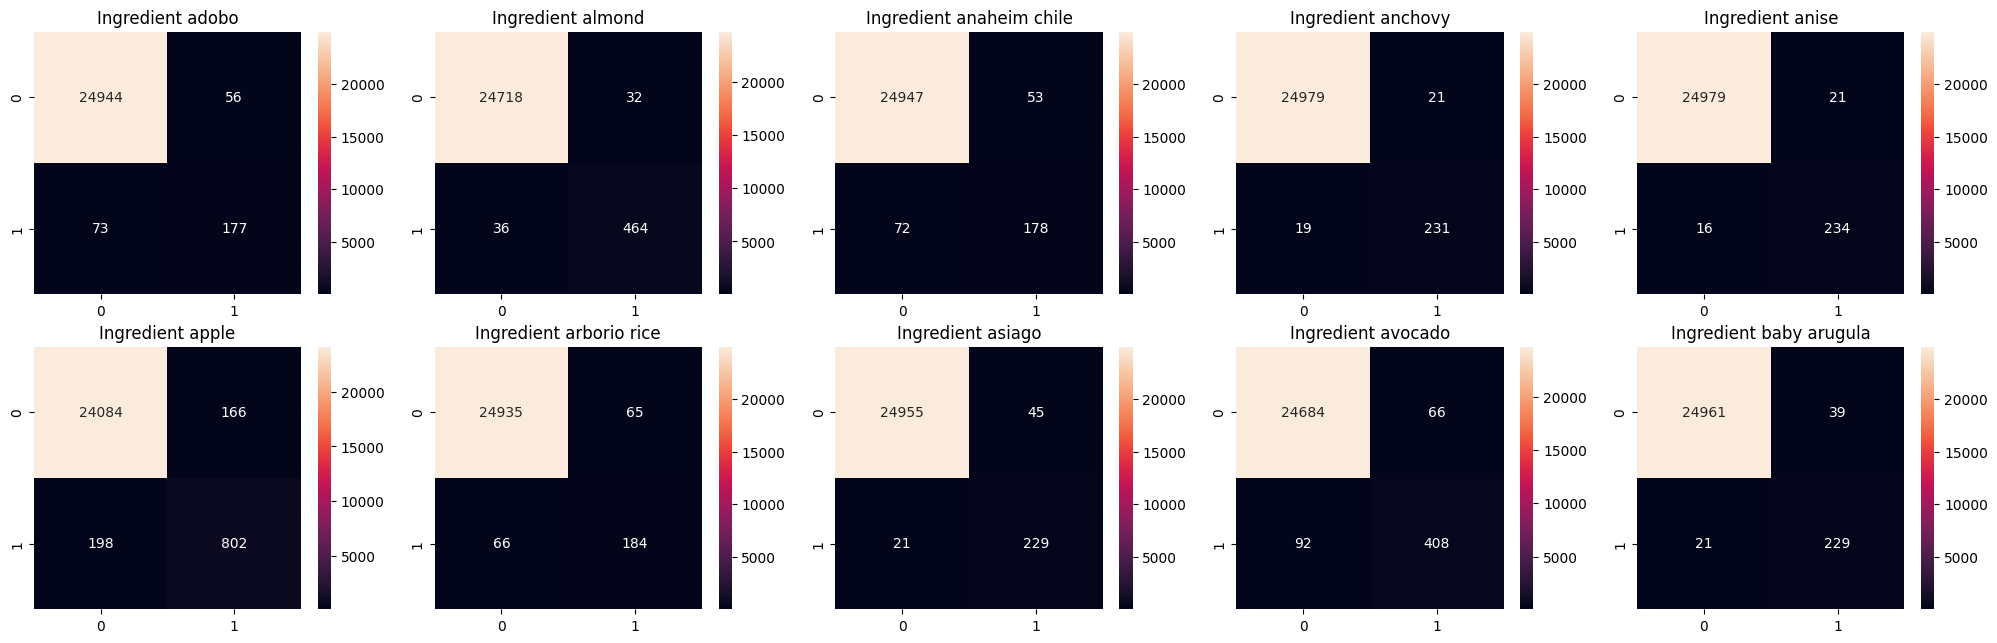

In [ ]:
#plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(confusion_matrix):
    fig, ax = plt.subplots(2, 5, figsize=(25, 7.5))

    for i in range(10):
        sns.heatmap(confusion_matrix[i], annot=True, fmt='d', ax=ax[i//5, i%5])
        ax[i//5, i%5].set_title(f'Ingredient {idx_to_ingredient[i]}')

    plt.show()

plot_confusion_matrix(confusion_matrix)

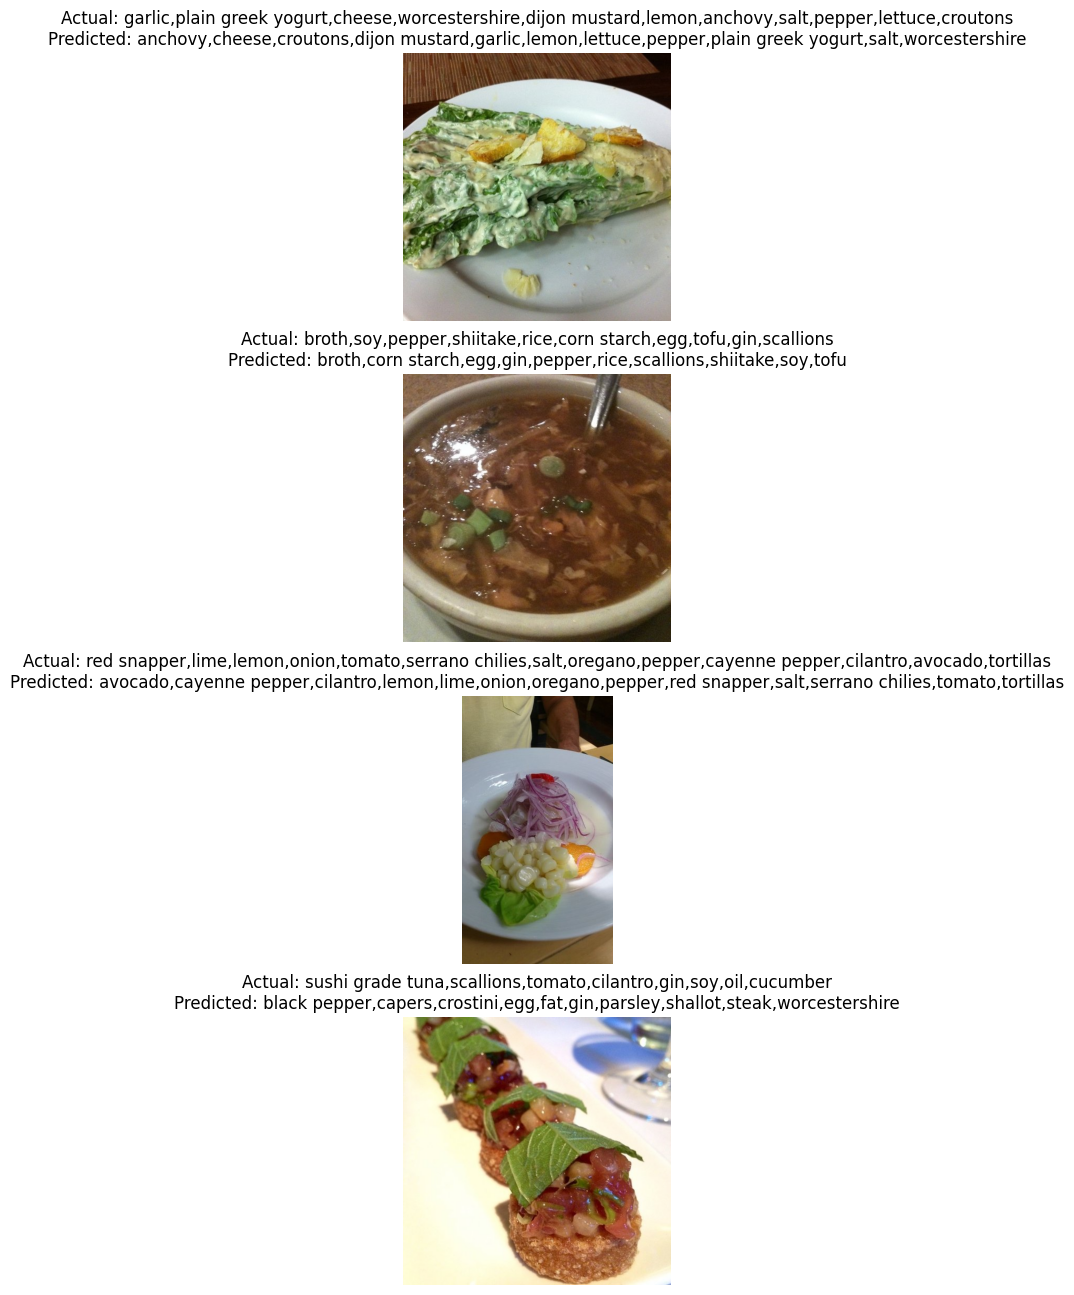

In [ ]:
import torch

def show_predictions(rows=2, cols=4):
    model.eval()
    samples = test_dataset.shuffle(seed=4).select(range(rows * cols))
    fig = plt.figure(figsize=(cols * 4, rows * 4))
    
    for i in range(rows * cols):
        img = samples[i]['image']
        labels = samples[i]['labels']
        inputs = samples[i]['pixel_values'].unsqueeze(0).to(device)
        inputs = valid_tfms(img).unsqueeze(0).to(device)
        labels = samples[i]['ingredients']
        
        labels_text = ','.join([idx_to_ingredient[label] for label in labels])
        
        with torch.no_grad():
            logits = model(inputs)
        
        predictions = logits.sigmoid() > threshold  # Anwenden der Sigmoid und Umwandeln in binäre Vorhersagen

        predictions = predictions.cpu().float().numpy().flatten() # convert boolean predictions to float


        pred_labels = np.where(predictions==1)[0] # find indices where prediction is 1
        pred_labels = ','.join([idx_to_ingredient[label] for label in pred_labels]) # converting integer labels to string
        
        # predicted_indices = predictions.nonzero(as_tuple=False).squeeze()  # Finden Sie die Indizes der Vorhersagen, die 1 sind
        # pred_labels_text = ','.join([idx_to_ingredient[label.item()] for label in predicted_indices])
        
        label = f"Actual: {labels_text}\nPredicted: {pred_labels}"
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')
    
    plt.show()

show_predictions(rows=4, cols=1)
